# **Compito Esercitazione 2**

* Import E2
* Data Loader E2
* Features E2
* **ZCR (intro, implementazione)**
* SVM E2 + **ZCRcombo (relazione)**

# Import E2

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Strumenti di classificazione
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Data Loader E2

In [2]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Features

In [3]:
def crop(input, size=100):
    # Elimina eventuali valori oltre il numero consentito
    output = input[0:min(size, input.shape[0])]
    # Aggiungi valori nulli per raggiungere la dimensione richiesta
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output
def sdev(input):
    return np.std(input, keepdims=True)
def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)
def duration(input):
    return input.shape
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

# ZCR

## Intro

La ZCR (Zero Crossing Rate) è la frequenza con cui il segnale analogico attraversa l'asse delle ascisse (valore nullo del segnale), o equivalentemente cambia di segno. Quest'ultima è la definizione adeguata per i segnali digitali e la base per esplicitare una formula da implementare.

$$ ZCR_{digital}(s(k)) = \frac{1}{2} \sum_{k=n}^{k=n+N-1}|sgn[s_w(k)]-sgn[s_w(k-1)]|$$

La funzione segno assume valori {-1, +1}, quindi il singolo termine della somma è +2 ogni volta che due istanti successivi assumono valore discorde. La metà della sommatoria conta i cambi di segno, per una finestra w lunga N campioni

## Implementazione

In [4]:
def zcr(input):
    padinput = np.array(crop(input, input.shape[0]+1)) 
    # si aggiunge alla sequenza un termine nullo, per avere lo slot per il segnale 1-lag
    
    scsv = np.zeros_like(padinput) # segnale 1-lag inizializzato a valori nulli 
    scsv[1:] = np.array(crop(input, input.shape[0])) # valori del segnale originale inseriti con lag pari a 1
    
    zc_count = 0.5*np.sum(np.absolute(np.sign(padinput)-np.sign(scsv)))
    # cfr formula scritta sopra, qui la sommatoria ha una finestra pari alla lunghezza dei segnali
    # si deve passare da frequenza assoluta a relativa
    zc_rate = zc_count / len(padinput)
    
    return (zc_rate, )

## SVM E2 + ZCRcombo (relazione)

In [5]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input)))

In [6]:
def combo_zcr(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input)))

SVM usando combo

In [7]:
# Caricamento dati
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo)

# Parametri da provare in cross validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

Addestramento completato in 5.020s


In [8]:
# Risultato della cross validation per la selezione dei parametri
print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

Migliore combinazione di parametri:
 C: 1000.0
 gamma: 0.5


Report di classificazione:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150

Matrice di confusione:
[[11  0  0  0  0  0  0  0  0  6]
 [ 0  4  2  2  0  1  0  0  1  0]
 [ 2  1  5  3  0  0  0  0  2  2]
 [ 0  3  7  8  0  0  0  0  0  1]
 [ 1  1  1  1  5  2  0  0  0  0]
 [ 1  0  0  1  4  4  1  0 

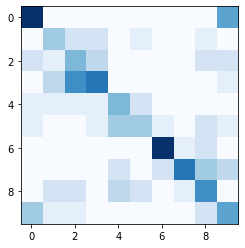

In [9]:
# Test
y_pred = clf.predict(X_test)

# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

SVM usando combo_zcr

In [10]:
# Caricamento dati
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_zcr)

# Parametri da provare in cross validation
param_grid = {'C': [1e2, 5e2, 1e3],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf2 = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf2 = clf2.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t0))

Addestramento completato in 3.333s


In [11]:
# Risultato della cross validation per la selezione dei parametri
print("Migliore combinazione di parametri:")
print(" C: "+str(clf2.best_estimator_.C))
print(" gamma: "+str(clf2.best_estimator_.gamma))

Migliore combinazione di parametri:
 C: 1000.0
 gamma: 0.1


Report di classificazione:
              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.53      0.90      0.67        10
           2       0.67      0.67      0.67        15
           3       0.79      0.58      0.67        19
           4       0.50      0.82      0.62        11
           5       0.43      0.43      0.43        14
           6       0.93      1.00      0.97        14
           7       0.80      0.42      0.55        19
           8       0.56      0.53      0.55        17
           9       0.65      0.79      0.71        14

    accuracy                           0.66       150
   macro avg       0.67      0.68      0.66       150
weighted avg       0.69      0.66      0.66       150

Matrice di confusione:
[[12  0  0  0  0  0  0  0  0  5]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 0  1 10  1  0  1  1  0  1  0]
 [ 0  2  3 11  1  2  0  0  0  0]
 [ 0  1  1  0  9  0  0  0  0  0]
 [ 0  0  1  0  4  6  0  1 

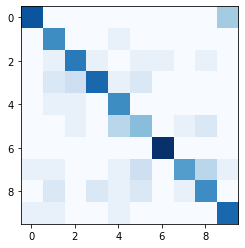

In [12]:
# Test
y_pred = clf2.predict(X_test)

# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione:")
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)
plt.imshow(cm2, cmap=plt.cm.Blues)

Dai report di classificazione, è evidente il miglioramento apportato dal calcolo della ZCR. L'accuracy generale aumenta dal 46% al 66%, la matrice di confusione e la sua heatmap sono evidentemente "diagonalizzate". Solo per la cifra "7" non si rileva un miglioramento netto della capacità di classificazione.
L'aggiunta della ZCR fornisce un proxy delle caratteristiche spettrali di un segnale, che sono a loro volta particolarmente legate alle vocali e consonanti che caratterizzano la dizione delle singole parole.